## Malicious URLs

Dataset Source: https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset

#### Install Necessary Libraries

In [20]:
%pip install torch transformers datasets evaluate sentencepiece
%pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:00


#### HuggingFace Login Via Command Line

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Mount Google Drive to Notebook

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Necessary Libraries

In [4]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed, DataCollatorWithPadding

import evaluate

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### Display Library Versions

In [5]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.10.1
         NumPy: 1.22.4
        Pandas: 1.5.3
      Datasets: 2.13.0
  Transformers: 4.30.2
         Torch: 2.0.1+cu118
      Evaluate: 0.4.0


#### Unzip Dataset File

In [6]:
#with ZipFile("/content/drive/MyDrive/projects/malicious URLs/archive (3).zip", 'r') as zObject:
#    zObject.extractall(path="/content/drive/MyDrive/projects/malicious URLs/")

#### Load & Start Preprocessing Dataset

In [7]:
names = ["text",
         "label"]

data_types = {
    "text": str,
    "label": str,
    }

data = pd.read_csv("/content/drive/MyDrive/projects/malicious URLs/malicious_phish.csv",
                   names=names,
                   dtype=data_types,
                   header=0)

data['text'] = data['text'].drop_duplicates().reset_index(drop=True)

data['label'] = data['label'].apply(lambda x: x.strip())

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641119 entries, 0 to 641118
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    641119 non-null  object
 1   label   641119 non-null  object
dtypes: object(2)
memory usage: 14.7+ MB


#### Define Dictionaries to Convert Between String & Integer Class Values

In [8]:
unique_labels = data['label'].unique()

id2label = {idx:label for idx, label in enumerate(unique_labels)}
label2id = {label:idx for idx, label in enumerate(unique_labels)}

NUM_OF_LABELS = len(unique_labels)

print(unique_labels)
print(NUM_OF_LABELS)
print(label2id)
print(id2label)

['phishing' 'benign' 'defacement' 'malware']
4
{'phishing': 0, 'benign': 1, 'defacement': 2, 'malware': 3}
{0: 'phishing', 1: 'benign', 2: 'defacement', 3: 'malware'}


#### Visual: Histogram of Text Lengths

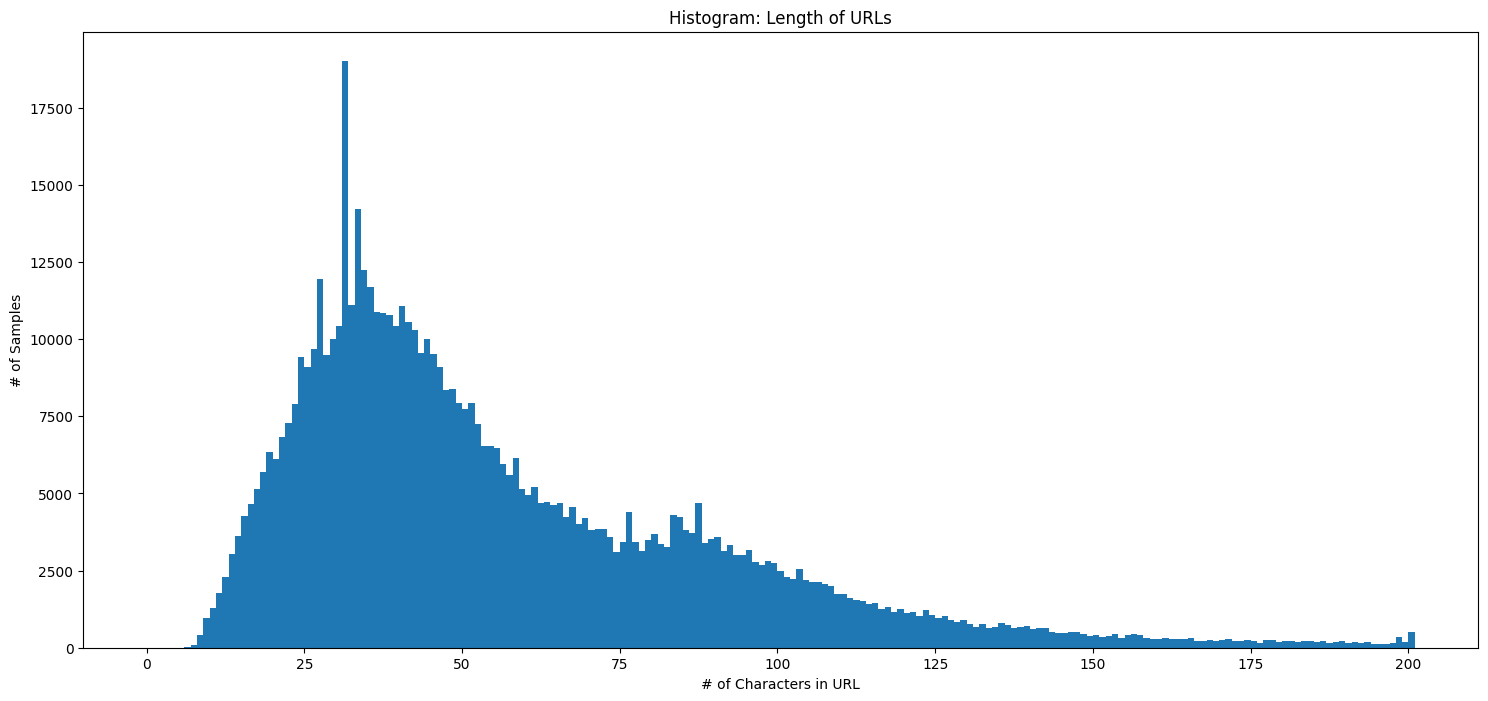

The maximum length of the URLs is 2175 characters.


In [9]:
data['text_length'] = data['text'].str.len()

n_bin=200
data.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin + 1), bins=(n_bin + 1))
plt.title('Histogram: Length of URLs')
plt.xlabel('# of Characters in URL')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of the URLs is {max(data['text_length'])} characters.")

#### Visual: Tweet Length by Class

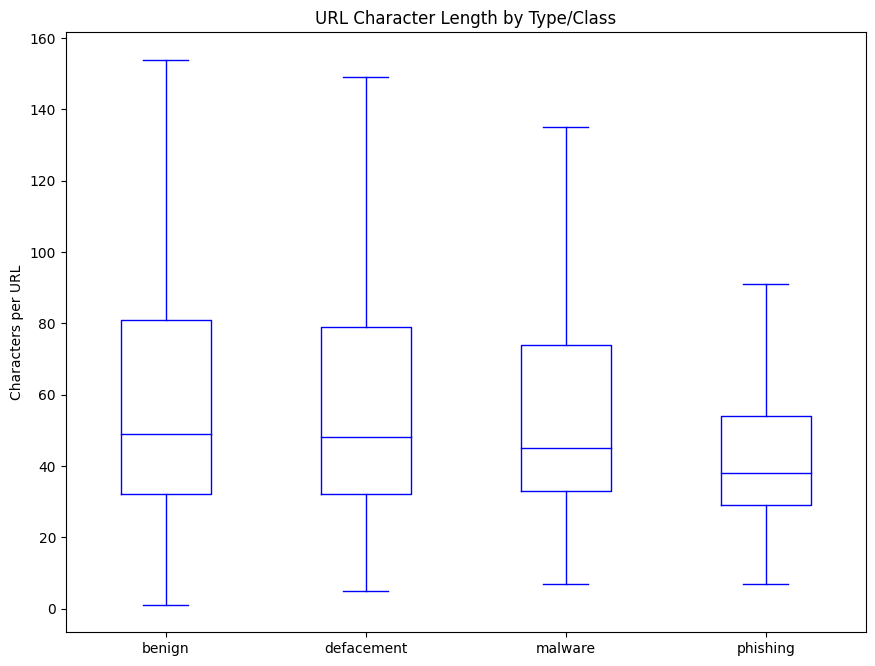

In [10]:
data.boxplot("text_length", by="label", grid=False, showfliers=False, color="Blue", figsize=(10,8))

plt.suptitle('')
plt.title('URL Character Length by Type/Class')
plt.xlabel('')
plt.ylabel('Characters per URL')
plt.show()

#### Final Data Preprocessing

In [11]:
data = data[data['text_length'] < 201]

data = data.drop(columns=["text_length"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630719 entries, 0 to 641118
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    630719 non-null  object
 1   label   630719 non-null  object
dtypes: object(2)
memory usage: 14.4+ MB


#### Barplot Function

In [12]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   show_class_amounts: bool = True
                   ):
    """
    This function returns a histogram for a feature.

    Inputs:
    - feature_to_visualize: Feature to plot in the form
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.

    Output:
    - A Bar Plot.
    """

    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."

    ax = feature_to_visualize.value_counts().plot.bar(
                                                      figsize=(8, 6),
                                                      rot=0,
                                                      legend=False,
                                                      color=["lightgreen",
                                                             "blue",
                                                             "tan",
                                                             "lightblue",
                                                             "brown",
                                                             "yellow",
                                                             "orange",
                                                             "green",
                                                             "red"]
                                                      )

    if show_class_amounts:
        ax.bar_label(ax.containers[0])

    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.show()

#### Number of Samples in Each Class

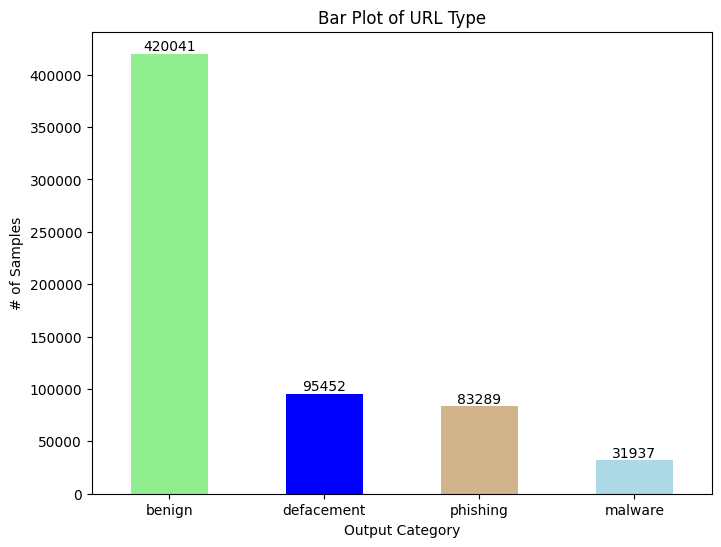

In [13]:
barplot_visual(data["label"],
               "Bar Plot of URL Type",
               "Output Category",
               "# of Samples",
               )

#### Convert Label Values From String to Integer

In [14]:
data['label'] = data['label'].replace(label2id).astype(np.int8)

#### Convert DataFrame to Dataset

In [15]:
dataset = Dataset.from_pandas(data)

#### Split Dataset into Training Evaluation Datasets

In [16]:
train_eval = dataset.train_test_split(train_size=0.67)

ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (422581, 3)
Evaluation Dataset Shape: (208138, 3)


#### Find Longest Tokenized Input Value

In [17]:
"""MODEL_CKPT = "microsoft/codebert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT,
                                             truncation=True,
                                             padding=True,
                                             batched=True,
                                             batch_size=2500)

text_len = [len(tokenizer.encode(a)) for a in dataset["text"]]

print(f"The longest article length is {max(text_len)} tokens.")"""

'MODEL_CKPT = "microsoft/codebert-base"\n\ntokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT,\n                                             truncation=True,\n                                             padding=True,\n                                             batched=True,\n                                             batch_size=2500)\n\ntext_len = [len(tokenizer.encode(a)) for a in dataset["text"]]\n\nprint(f"The longest article length is {max(text_len)} tokens.")'

#### Basic Values/Constants

In [22]:
set_seed = 42
NUM_OF_EPOCHS = 1

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = 239 #max(text_len) + 2
MODEL_CKPT = "microsoft/deberta-base-mnli"

WEIGHT_DECAY = 0.01
REPORTS_TO = "tensorboard"

MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Malicious_URLs"
METRIC_NAME = "f1"

STRATEGY = 'epoch'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GRAD_ACC_STEPS = 4

print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")
print(f"The model checkpoint used for this project is: {MODEL_CKPT}")

This project will have a maximum length for the input text of 239 tokens.
The model checkpoint used for this project is: microsoft/deberta-base-mnli


#### Tokenize Entire Dataset

In [23]:
# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Tokenize Method
def tokenize(batch):
    return tokenizer(batch['text'],
                     padding=True,
                     truncation=True,
                     max_length=MAX_LENGTH,
                     return_tensors="pt")

# Tokenize entire dataset
encoded_data = ds.map(tokenize,
                      batched=True,
                      batch_size=2500)

print('Training data shape:', encoded_data['train'].shape)
print('Validation data shape:', encoded_data['eval'].shape)

print(encoded_data['train'].features)
print(encoded_data['train'])

Map:   0%|          | 0/422581 [00:00<?, ? examples/s]

Map:   0%|          | 0/208138 [00:00<?, ? examples/s]

Training data shape: (422581, 6)
Validation data shape: (208138, 6)
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int8', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 422581
})


#### Instantiate Model

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    ignore_mismatched_sizes=True
    ).to(DEVICE)

Some weights of the model checkpoint at microsoft/deberta-base-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base-mnli and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3])

#### Define Function to Compute Metrics

In [27]:
def compute_metrics(p):
    """
    This function takes the predictions output from
    trainer.evaluate & returns metrics (accuracy, F1,
    recall, & precision) for a multiclass
    classification project.
    """
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions,
                                                             axis=1),
                                       references=p.label_ids)['accuracy']

    ### ------------------- F1 scores -------------------

    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions,
                                                                      axis=1),
                                                references=p.label_ids,
                                                average='weighted')["f1"]

    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions,
                                                                   axis=1),
                                             references=p.label_ids,
                                             average='micro')['f1']

    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions,
                                                                   axis=1),
                                             references=p.label_ids,
                                             average='macro')["f1"]

    ### ------------------- recall -------------------

    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions,
                                                                  axis=1),
                                            references=p.label_ids,
                                            average='weighted')["recall"]

    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions,
                                                               axis=1),
                                         references=p.label_ids,
                                         average='micro')["recall"]

    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions,
                                                               axis=1),
                                         references=p.label_ids,
                                         average='macro')["recall"]

    ### ------------------- precision -------------------

    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions,
                                                                        axis=1),
                                                  references=p.label_ids,
                                                  average='weighted')["precision"]

    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions,
                                                                     axis=1),
                                               references=p.label_ids,
                                               average='micro')["precision"]

    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions,
                                                                     axis=1),
                                               references=p.label_ids,
                                               average='macro')["precision"]

    return {"accuracy" : accuracy,
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [33]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    auto_find_batch_size=True,
    gradient_checkpointing=True,
    gradient_accumulation_steps=GRAD_ACC_STEPS,
    weight_decay=WEIGHT_DECAY,
    log_level="error",
    logging_strategy='steps',
    group_by_length=True,
    report_to=REPORTS_TO,
    logging_steps=250,
    evaluation_strategy='no',
    save_strategy=STRATEGY,
    logging_first_step=True,
    disable_tqdm=False,
    hub_private_repo=True,
    fp16=True,
    push_to_hub=True
)

#### Define Data Collator

In [34]:
data_collator = DataCollatorWithPadding(tokenizer,
                                        padding=True)

#### Subclass Trainer to Handle Class Imbalance

In [35]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(
            [
                1.0,
                1.0,
                1.0,
                1.0
                ]
            ).to(DEVICE)
        )
        loss = loss_fct(logits.view(-1,
                                    self.model.config.num_labels
                                    ),
                        labels.view(-1)
                        )
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [36]:
trainer = CustomTrainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'],
                  eval_dataset=encoded_data['eval'],
                  data_collator=data_collator,
                  tokenizer=tokenizer)

/content/deberta-base-mnli-Malicious_URLs is already a clone of https://huggingface.co/DunnBC22/deberta-base-mnli-Malicious_URLs. Make sure you pull the latest changes with `repo.git_pull()`.


#### Train Model

In [37]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,0.749600
250,0.832500
500,0.837200
750,0.820600
1000,0.800200
1250,0.809200
1500,0.811000
1750,0.790300
2000,0.813200
2250,0.795000


#### Save Model & Metrics on Training Dataset

In [38]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/531M [00:00<?, ?B/s]

Upload file runs/Jun22_15-29-47_f7092f1b3349/events.out.tfevents.1687447922.f7092f1b3349.497.1:   0%|         …

To https://huggingface.co/DunnBC22/deberta-base-mnli-Malicious_URLs
   68682fa..a8f9119  main -> main

   68682fa..a8f9119  main -> main

To https://huggingface.co/DunnBC22/deberta-base-mnli-Malicious_URLs
   a8f9119..5496feb  main -> main

   a8f9119..5496feb  main -> main



***** train metrics *****
  epoch                    =        1.0
  total_flos               = 36450310GF
  train_loss               =       0.78
  train_runtime            = 2:58:59.84
  train_samples_per_second =     39.347
  train_steps_per_second   =       1.23


#### Evaluate Model

In [39]:
metrics = trainer.evaluate()

print(metrics)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.758034884929657, 'eval_accuracy': 0.7353390538969338, 'eval_Weighted F1': 0.6585598476041514, 'eval_Micro F1': 0.7353390538969338, 'eval_Macro F1': 0.45325833939858134, 'eval_Weighted Recall': 0.7353390538969338, 'eval_Micro Recall': 0.7353390538969338, 'eval_Macro Recall': 0.43146982136714085, 'eval_Weighted Precision': 0.629120963844447, 'eval_Micro Precision': 0.7353390538969338, 'eval_Macro Precision': 0.5684138681336973, 'eval_runtime': 1250.5743, 'eval_samples_per_second': 166.434, 'eval_steps_per_second': 20.805, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Push Model to HuggingFace Hub

In [40]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Upload file runs/Jun22_15-29-47_f7092f1b3349/events.out.tfevents.1687459988.f7092f1b3349.497.2: 100%|#########…

To https://huggingface.co/DunnBC22/deberta-base-mnli-Malicious_URLs
   5496feb..5aef2d0  main -> main

   5496feb..5aef2d0  main -> main

To https://huggingface.co/DunnBC22/deberta-base-mnli-Malicious_URLs
   5aef2d0..d3b7e40  main -> main

   5aef2d0..d3b7e40  main -> main



'https://huggingface.co/DunnBC22/deberta-base-mnli-Malicious_URLs/commit/5aef2d0e5c2e8aa9de6e6c47a4b0e3c8bd33019b'

### Notes & Other Takeaways From This Project
****
-

****

### Citations
- Model Checkpoint (RoBERTa)
    > @article{DBLP:journals/corr/abs-1907-11692, author = {Yinhan Liu and Myle Ott and Naman Goyal and Jingfei Du and Mandar Joshi and Danqi Chen and Omer Levy and Mike Lewis and Luke Zettlemoyer and Veselin Stoyanov}, title = {RoBERTa: {A} Robustly Optimized {BERT} Pretraining Approach}, journal = CoRR}, volume = {abs/1907.11692}, year = {2019}, url = {http://arxiv.org/abs/1907.11692}, archivePrefix = {arXiv}, eprint = {1907.11692}, timestamp = {Thu, 01 Aug 2019 08:59:33 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-1907-11692.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Model Checkpoint (DeBERTa)
    > @misc{he2021debertav3, title={DeBERTaV3: Improving DeBERTa using ELECTRA-Style Pre-Training with Gradient-Disentangled Embedding Sharing}, author={Pengcheng He and Jianfeng Gao and Weizhu Chen}, year={2021}, eprint={2111.09543}, archivePrefix={arXiv}, primaryClass={cs.CL}}
